In [1]:
# imports
from importlib import reload

import os # a module to interact with the operating system
os.environ["ENDPOINT_URL"]="http://rook-ceph-rgw-nautiluss3.rook"
import numpy as np

import pandas
import xarray
import h5py
import random
import healpy as hp

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from matplotlib import pyplot as plt
import seaborn as sns

from ulmo import io as ulmo_io
from ulmo import plotting
from ulmo.llc import io as llc_io
from ulmo.llc import plotting as llc_plotting

from ulmo.utils import image_utils
from ulmo.analysis import figures as ulmo_figs
from ulmo.plotting import plotting as ulmo_plotting

In [2]:
os.getenv('ENDPOINT_URL') 
tbl_file = 's3://llc/Tables/test_noise_modis2012.parquet'
llc_table = ulmo_io.load_main_table(tbl_file)

Read main table: s3://llc/Tables/test_noise_modis2012.parquet


# Re-written Functions

In [45]:
def evals_to_healpix(eval_tbl, nside, log=False, mask=True):
    """
    Generate a healpix map of where the input
    MHW Systems are located on the globe

    Parameters
    ----------
    mhw_sys : pandas.DataFrame
    nside : int  # nside is a number that sets the resolution of map
    mask : bool, optional

    Returns
    -------
    healpix_array, lats, lons : hp.ma, np.ndarray, np.ndarray

    """
    # Grab lats, lons
    lats = eval_tbl.lat.values
    lons = eval_tbl.lon.values

    # Grab LL values
    vals = eval_tbl.LL.values

    # Healpix coords
    theta = (90 - lats) * np.pi / 180.  # convert into radians
    phi = lons * np.pi / 180.
    idx_all = hp.pixelfunc.ang2pix(nside, theta, phi) # returns the healpix pixel numbers that correspond to theta and phi values

    # Count events
    npix_hp = hp.nside2npix(nside)  # returns the number of pixels on map, based on nside parameter
    all_events = np.ma.masked_array(np.zeros(npix_hp, dtype='int')) # array of all pixels on map
    all_values = np.ma.masked_array(np.zeros(npix_hp, dtype='int')) # will contain a sum of all LL values in the area

    #A masked array takes an input data array and mask array of same size; mask is a sequence of boolean values (True == turn mask on; False ==  unmasked)
    for i, idx in enumerate(idx_all):
        all_events[idx] += 1 # pixels concentrated with data pts >= 1 ; those without data remain 0
        all_values[idx] += vals[i] 

    zero = all_events == 0 
    if log:  #(defaults to False)
        float_events = np.zeros_like(all_events).astype(float) # Return an array of zeros with the same shape and type as a given array
        float_values = np.zeros_like(all_events).astype(float)

        float_events[~zero] = np.log10(all_events[~zero].astype(float)) 
# ~ operator is called the complement bitwise operator 
# inverts the True/False values
# [~zero] selects pixels where the cutouts are (where events = 1 exist)
        float_values[~zero] = all_values[~zero]/all_events[~zero]
    else:
        float_events = all_events.astype(float)
        float_values = all_values.astype(float)


    # Mask
    hpma = hp.ma(float_events)
    hpma1 = hp.ma(float_values)
    if mask:  # if you want to mask float_events
        hpma.mask = zero # current mask set to zero array, where Trues (no events) are masked
        hpma1.mask = zero 

    # Angles
    hp_lons, hp_lats = hp.pixelfunc.pix2ang(nside, np.arange(npix_hp), lonlat=True)

    # Return
    return hpma, hp_lons, hp_lats, hpma1

In [46]:
def show_spatial(main_tbl:pandas.DataFrame, 
                 nside=64, use_log=True, 
                 use_mask=True, tricontour=False,
                 lbl=None, figsize=(12,8), 
                 color='viridis', show=True):
    """Generate a global map of the location of the input
    cutouts

    Args:
        main_tbl (pandas.DataFrame): table of cutouts
        nside (int, optional): [description]. Defaults to 64.
        use_log (bool, optional): [description]. Defaults to True.
        use_mask (bool, optional): [description]. Defaults to True.
        tricontour (bool, optional): [description]. Defaults to False.
        lbl ([type], optional): [description]. Defaults to None.
        figsize (tuple, optional): [description]. Defaults to (12,8).
        color (str, optional): [description]. Defaults to 'Reds'.
        show (bool, optional): If True, show on the screen.  Defaults to True

    Returns:
        matplotlib.Axis: axis holding the plot
    """
    # Healpix me
    hp_events, hp_lons, hp_lats, hp_values = evals_to_healpix(
        main_tbl, nside, log=use_log, mask=use_mask)
    
    # Figure
    
    fig = plt.figure(figsize=figsize)
    plt.clf()

    tformM = ccrs.Mollweide()
    tformP = ccrs.PlateCarree()

    ax = plt.axes(projection=tformM)

    if tricontour:
        cm = plt.get_cmap(color)
        img = ax.tricontourf(hp_lons, hp_lats, hp_values, transform=tformM,
                         levels=20, cmap=cm)#, zorder=10)
    else:
        cm = plt.get_cmap(color)
        # Cut
        good = np.invert(hp_values.mask)
        img = plt.scatter(x=hp_lons[good],
            y=hp_lats[good],
            c=hp_values[good], vmin = -2000, vmax = 500, 
            cmap=cm,
            s=1,
            transform=tformP)

    # Colorbar
    cb = plt.colorbar(img, orientation='horizontal', pad=0.)
    if lbl is not None:
        #clbl=r'$\log_{10} \, N_{\rm '+'{}'.format(lbl)+'}$'
        clbl = 'mean_LL'
        cb.set_label(clbl, fontsize=20.)
    cb.ax.tick_params(labelsize=17)

    # Coast lines
    if not tricontour:
        ax.coastlines(zorder=10)
        ax.set_global()
    
        gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, 
            color='black', alpha=0.5, linestyle=':', draw_labels=True)
        gl.xlabels_top = False
        gl.ylabels_left = True
        gl.ylabels_right=False
        gl.xlines = True
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'color': 'black'}# 'weight': 'bold'}
        gl.ylabel_style = {'color': 'black'}# 'weight': 'bold'}
        #gl.xlocator = mticker.FixedLocator([-180., -160, -140, -120, -60, -20.])
        #gl.xlocator = mticker.FixedLocator([-240., -180., -120, -65, -60, -55, 0, 60, 120.])
        #gl.ylocator = mticker.FixedLocator([0., 15., 30., 45, 60.])


    # Layout and save
    if show:
        plt.show()

    return ax

In [37]:
llc_table['DT'] = llc_table['T90'] - llc_table['T10']

In [38]:
sub_tbl = llc_table[(llc_table.modis_datetime > pandas.to_datetime('2012-11-15 11:35:00'))]
sub_tbl.head()

,modis_lat,modis_lon,modis_col,modis_datetime,modis_LL,modis_row,clear_fraction,mean_temperature,Tmin,Tmax,...,pp_type,pp_idx,lat,lon,row,col,datetime,filename,LL,DT


In [41]:
a = np.array( [[8, 12], [30, 40]])
b = np.array( [[2, 2], [2, 2]])
a/b

array([[ 4.,  6.],
       [15., 20.]])

# mean LL distribution for LLC

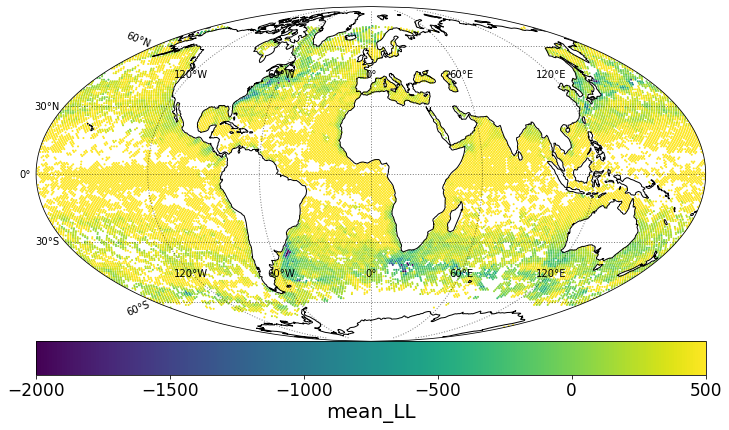

<GeoAxesSubplot:>

In [47]:
show_spatial(llc_table, lbl = True)

In [48]:
new_tbl_file = 's3://modis-l2/Tables/MODIS_L2_std.parquet'
mod_table = ulmo_io.load_main_table(new_tbl_file)

Read main table: s3://modis-l2/Tables/MODIS_L2_std.parquet


In [49]:
mod_table['DT'] = mod_table['T90'] - mod_table['T10']

In [50]:
year_2012 = mod_table[(mod_table.datetime >= pandas.to_datetime('2012-01-01 00:00:00')) & (mod_table.datetime < pandas.to_datetime('2012-11-15 11:35:00'))]

# mean_LL distribution for MODIS

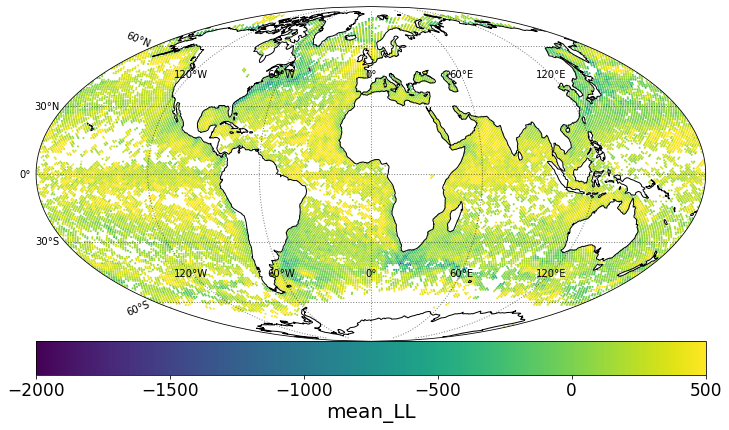

<GeoAxesSubplot:>

In [51]:
show_spatial(year_2012, lbl = True)

# Difference between mean_LL distributions

In [71]:
def show_spatial_two(tbl1:pandas.DataFrame, tbl2:pandas.DataFrame, 
                 nside=64, use_log=True, 
                 use_mask=True, tricontour=False,
                 lbl=None, figsize=(12,8), 
                 color='seismic', show=True):
    """Generate a global map of the location of the input
    cutouts

    Args:
        main_tbl (pandas.DataFrame): table of cutouts
        nside (int, optional): [description]. Defaults to 64.
        use_log (bool, optional): [description]. Defaults to True.
        use_mask (bool, optional): [description]. Defaults to True.
        tricontour (bool, optional): [description]. Defaults to False.
        lbl ([type], optional): [description]. Defaults to None.
        figsize (tuple, optional): [description]. Defaults to (12,8).
        color (str, optional): [description]. Defaults to 'Reds'.
        show (bool, optional): If True, show on the screen.  Defaults to True

    Returns:
        matplotlib.Axis: axis holding the plot
    """
    # Healpix me
    hp_events1, hp_lons1, hp_lats1, hp_values1 = evals_to_healpix(
        tbl1, nside, log=use_log, mask=use_mask)
    
    hp_events2, hp_lons2, hp_lats2, hp_values2 = evals_to_healpix(
        tbl2, nside, log=use_log, mask=use_mask)
    
    # Figure
    
    fig = plt.figure(figsize=figsize)
    plt.clf()

    tformM = ccrs.Mollweide()
    tformP = ccrs.PlateCarree()

    ax = plt.axes(projection=tformM)

    if tricontour:
        cm = plt.get_cmap(color)
        img = ax.tricontourf(hp_lons1, hp_lats1, hp_values1 - hp_values2, transform=tformM,
                         levels=20, cmap=cm)#, zorder=10)
    else:
        cm = plt.get_cmap(color)
        # Cut
        good = np.invert(hp_values.mask)
        img = plt.scatter(x=hp_lons2[good],
            y=hp_lats2[good],
            c=hp_values1[good]- hp_values2[good], vmin = -1000, vmax = 1000, 
            cmap=cm,
            s=1,
            transform=tformP)

    # Colorbar
    cb = plt.colorbar(img, orientation='horizontal', pad=0.)
    if lbl is not None:
        #clbl=r'$\log_{10} \, N_{\rm '+'{}'.format(lbl)+'}$'
        clbl = 'diff_mean_LL'
        cb.set_label(clbl, fontsize=20.)
    cb.ax.tick_params(labelsize=17)

    # Coast lines
    if not tricontour:
        ax.coastlines(zorder=10)
        ax.set_global()
    
        gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, 
            color='black', alpha=0.5, linestyle=':', draw_labels=True)
        gl.xlabels_top = False
        gl.ylabels_left = True
        gl.ylabels_right=False
        gl.xlines = True
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'color': 'black'}# 'weight': 'bold'}
        gl.ylabel_style = {'color': 'black'}# 'weight': 'bold'}
        #gl.xlocator = mticker.FixedLocator([-180., -160, -140, -120, -60, -20.])
        #gl.xlocator = mticker.FixedLocator([-240., -180., -120, -65, -60, -55, 0, 60, 120.])
        #gl.ylocator = mticker.FixedLocator([0., 15., 30., 45, 60.])


    # Layout and save
    if show:
        plt.show()

    return ax

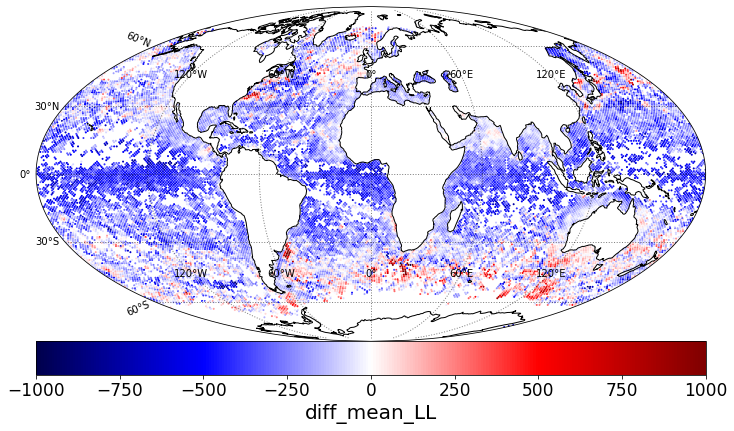

<GeoAxesSubplot:>

In [72]:
show_spatial_two(year_2012, llc_table, lbl=True)

# Pick a random cutout

In [28]:
num = random.randrange(0, llc_table.shape[0], 1)
num

11165

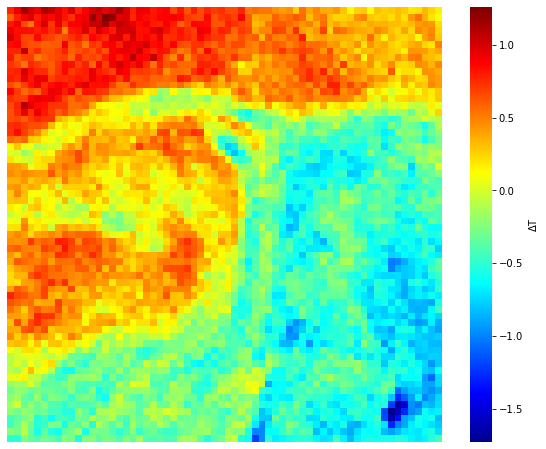

In [29]:
_, cm = ulmo_plotting.load_palette()

cutout = llc_table.iloc[num]

img = llc_io.grab_image(cutout)

fig = plt.figure( figsize = (10, 8))
ax = fig.add_subplot(1,1,1)
ax = sns.heatmap(np.flipud(img), xticklabels=[], yticklabels=[], cmap=cm, cbar=True, square = True,
                 cbar_kws={'label': r'$\Delta$T'})
#ax.set_title('Random Cutout', fontsize = 12)
plt.show()

In [46]:
cutout

modis_lat                                                    -33.8796
modis_lon                                                   53.873993
modis_col                                                         581
modis_datetime                                    2012-01-07 21:35:00
modis_LL                                                    44.055542
modis_row                                                         368
clear_fraction                                               0.012878
mean_temperature                                            20.778141
Tmin                                                        19.088001
Tmax                                                        21.872002
T90                                                         21.434002
T10                                                         20.174999
modis_filename                   AQUA_MODIS.20120107T213508.L2.SST.nc
modis_UID                                          132556120423387399
pp_file             

# Spatial Distribution

/opt/conda/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:324: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/conda/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:348: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '
/opt/conda/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:360: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


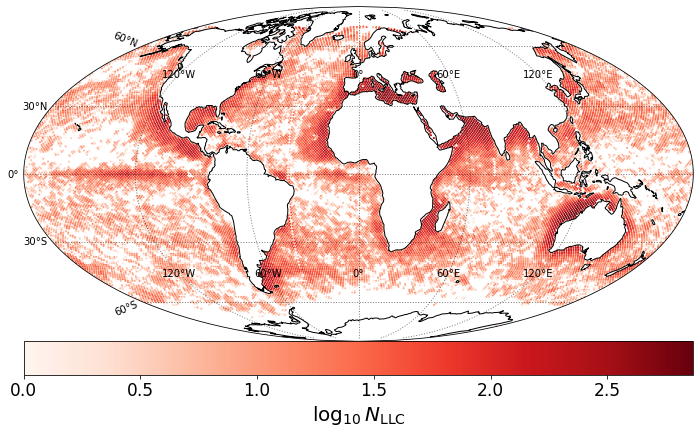

In [13]:
_ = ulmo_figs.show_spatial(llc_table, lbl='LLC' )

# Modis Data

In [5]:
new_tbl_file = 's3://modis-l2/Tables/MODIS_L2_std.parquet'
mod_table = ulmo_io.load_main_table(new_tbl_file)

Read main table: s3://modis-l2/Tables/MODIS_L2_std.parquet


In [31]:
mod_table['DT'] = mod_table['T90'] - mod_table['T10']

In [32]:
mod_table.head()

,lat,lon,col,datetime,LL,row,clear_fraction,mean_temperature,Tmin,Tmax,T90,T10,filename,UID,pp_file,pp_root,field_size,pp_type,pp_idx,DT
0,13.980967,62.675774,517,2003-03-10 21:25:00,520.178711,304,0.000000,26.199476,25.250000,26.885000,26.474998,25.814999,AQUA_MODIS.20030310T212506.L2.SST.nc,1047103981024267577,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,0,0.660000
1,13.043748,-102.751816,706,2003-12-12 08:30:00,432.766724,1696,0.049805,28.924648,27.789999,29.654999,29.154999,28.695000,AQUA_MODIS.20031212T083006.L2.SST.nc,107110304377724818,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,1,0.459999
2,-18.086618,40.844833,581,2003-09-24 22:35:00,764.413086,656,0.006104,25.551611,24.775000,26.154999,25.750000,25.344999,AQUA_MODIS.20030924T223506.L2.SST.nc,106471913422084483,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,2,0.405001
3,39.071575,18.569141,1028,2003-05-01 01:05:00,371.310120,898,0.049988,16.414951,15.160000,17.205000,16.725000,16.080000,AQUA_MODIS.20030501T010506.L2.SST.nc,1051129071619856914,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,3,0.645000
4,17.901926,90.155480,997,2003-12-05 19:55:00,-214.759277,1520,0.035461,26.744499,24.975000,28.724998,27.824999,25.830000,AQUA_MODIS.20031205T195506.L2.SST.nc,1070107901927015548,s3://modis-l2/PreProc/MODIS_R2019_2003_95clear...,standard,128,0,4,1.994999


In [50]:
year_2012 = mod_table[(mod_table.datetime >= pandas.to_datetime('2012-01-01 00:00:00')) & (mod_table.datetime < pandas.to_datetime('2012-11-15 11:35:00'))]

In [34]:
new_cutout = year_2012.iloc[0]
new_cutout

lat                                                          36.13574
lon                                                         -3.848738
col                                                               453
datetime                                          2012-01-01 02:05:00
LL                                                         318.187195
row                                                               816
clear_fraction                                               0.024536
mean_temperature                                             15.80138
Tmin                                                            14.62
Tmax                                                        16.594999
T90                                                            16.205
T10                                                         15.304999
filename                         AQUA_MODIS.20120101T020508.L2.SST.nc
UID                                               1325126135717615126
pp_file             

In [19]:
ds = xarray.load_dataset(ulmo_io.open(new_cutout.filename, 'rb'))
ds

FileNotFoundError: [Errno 2] No such file or directory: 'AQUA_MODIS.20120101T020508.L2.SST.nc'

## Spatial Distribution

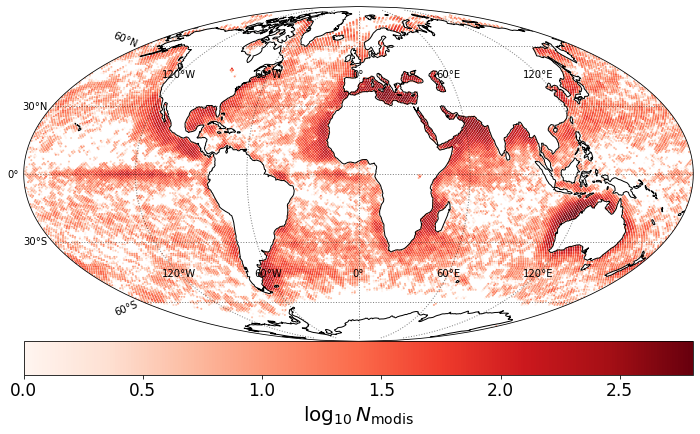

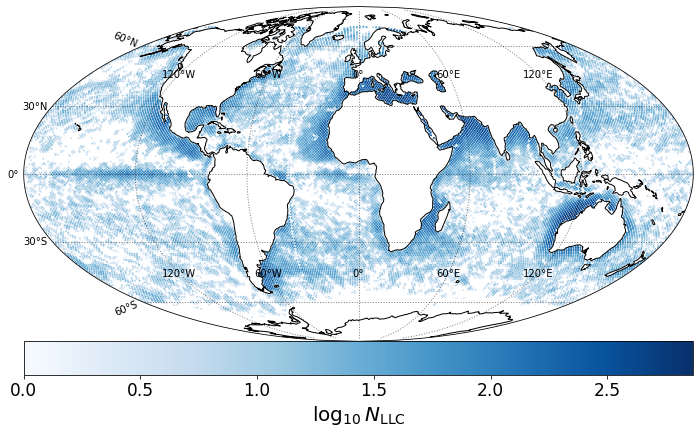

In [52]:
_ = ulmo_figs.show_spatial(year_2012, lbl='modis' )
_ = ulmo_figs.show_spatial(llc_table, lbl='LLC', color = 'Blues' )

# LL Histogram

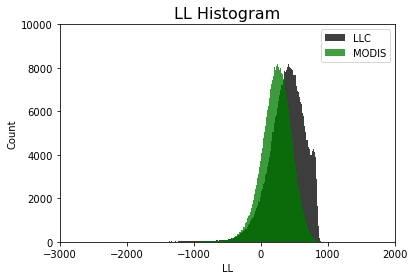

In [53]:
ax = sns.histplot(data= llc_table, x='LL', color = 'k', stat = 'count', label = 'LLC')
ax = sns.histplot(data= year_2012, x='LL', color = 'g', stat = 'count', label = 'MODIS')
ax.set_xlim(-3000., 2000.)
ax.set_ylim(0., 10000)
ax.set_title('LL Histogram', fontsize = 16)
ax.legend()

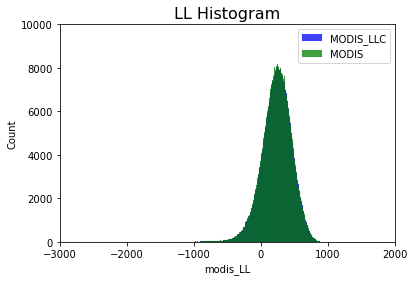

In [54]:
ax = sns.histplot(data= llc_table, x='modis_LL', color = 'b', stat = 'count', label = 'MODIS_LLC')
ax = sns.histplot(data= year_2012, x='LL', color = 'g', stat = 'count', label = 'MODIS')
ax.set_xlim(-3000., 2000.)
ax.set_ylim(0., 10000)
ax.set_title('LL Histogram', fontsize = 16)
ax.legend()

In [56]:
llc_table.shape

(635295, 27)

In [57]:
year_2012.shape[0] - llc_table.shape[0]

12449

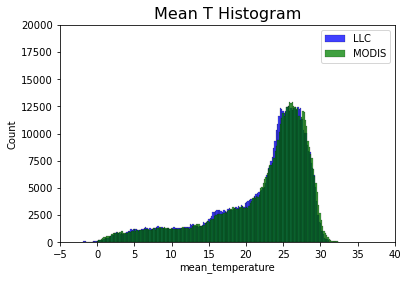

In [58]:
ax = sns.histplot(data= llc_table, x='mean_temperature', color = 'b', stat = 'count', label = 'LLC')
ax = sns.histplot(data= year_2012, x='mean_temperature', color = 'g', stat = 'count', label = 'MODIS')
ax.set_xlim(-5, 40.)
ax.set_ylim(0., 20000)
ax.set_title('Mean T Histogram', fontsize = 16)
ax.legend()

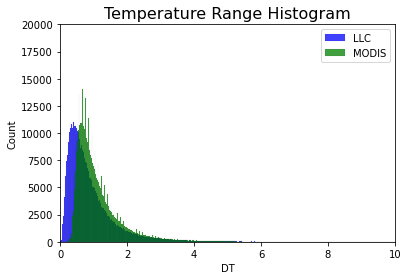

In [61]:
ax = sns.histplot(data= llc_table, x='DT', color = 'b', stat = 'count', label = 'LLC')
ax = sns.histplot(data= year_2012, x='DT', color = 'g', stat = 'count', label = 'MODIS')
ax.set_xlim(0, 10.)
ax.set_ylim(0., 20000)
ax.set_title('Temperature Range Histogram', fontsize = 16)
ax.legend()

## MODIS: Equatorial Pacific

In [67]:
in_pacific = (year_2012.lon > -180.) & (year_2012.lon < -80.)
near_equator = (year_2012.lat > -10) & (year_2012.lat < 10)

#zone 1
zone1_modis = year_2012[in_pacific & near_equator]

In [68]:
in_pacific = (llc_table.lon > -180.) & (llc_table.lon < -80.)
near_equator = (llc_table.lat > -10) & (llc_table.lat < 10)

#zone 1
zone1_llc = llc_table[in_pacific & near_equator]

In [69]:
zone1_modis.shape

(32077, 20)

In [71]:
zone1_llc.shape

(31988, 27)

Text(0.5, 1.0, 'Temperature Range Histogram: Equatorial Pacific')

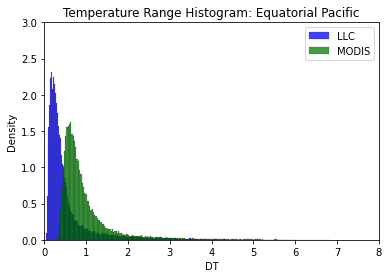

In [92]:
ax1_dt = sns.histplot(data= zone1_llc, x='DT', color = 'b', stat = 'density', label = 'LLC')
ax1_dt = sns.histplot(data= zone1_modis, x='DT', color = 'g', stat = 'density', label = 'MODIS')

ax1_dt.set_xlim(0., 8.)
ax1_dt.set_ylim(0., 3)
ax1_dt.legend()
ax1_dt.set_title('Temperature Range Histogram: Equatorial Pacific')

## MODIS: Off Cape Town

In [75]:
current = (llc_table.lon > 0.) & (llc_table.lon < 50.)
below_africa = (llc_table.lat > -50) & (llc_table.lat < -30)

#zone 4
zone4_llc = llc_table[current & below_africa]

In [76]:
current = (year_2012.lon > 0.) & (year_2012.lon < 50.)
below_africa = (year_2012.lat > -50) & (year_2012.lat < -30)

#zone 4
zone4_modis = year_2012[current & below_africa]

In [77]:
zone4_llc.shape

(12738, 27)

In [78]:
zone4_modis.shape

(12767, 20)

Text(0.5, 1.0, 'Temperature Range Histogram: Off Cape Town')

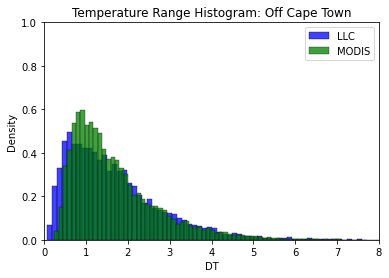

In [93]:
ax1_dt = sns.histplot(data= zone4_llc, x='DT', color = 'b', stat = 'density', label = 'LLC')
ax1_dt = sns.histplot(data= zone4_modis, x='DT', color = 'g', stat = 'density', label = 'MODIS')
ax1_dt.set_xlim(0., 8.)
ax1_dt.set_ylim(0., 1)
ax1_dt.legend()
ax1_dt.set_title('Temperature Range Histogram: Off Cape Town')

## MODIS: South American East Coast

In [80]:
in_atlantic = (year_2012.lon > -70.) & (year_2012.lon < -40.)
below_equator = (year_2012.lat > -50) & (year_2012.lat < -30)

#zone 3
zone3_modis = year_2012[in_atlantic & below_equator]

In [81]:
in_atlantic = (llc_table.lon > -70.) & (llc_table.lon < -40.)
below_equator = (llc_table.lat > -50) & (llc_table.lat < -30)

#zone 3
zone3_llc = llc_table[in_atlantic & below_equator]

In [83]:
zone3_modis.shape

(20409, 20)

In [84]:
zone3_llc.shape

(20342, 27)

Text(0.5, 1.0, 'Temperature Range Histogram: South American East Coast')

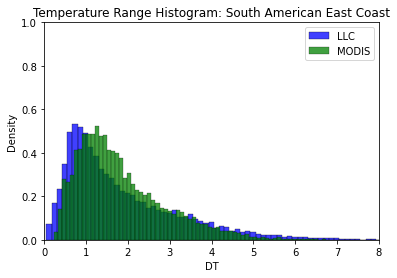

In [94]:
ax1_dt = sns.histplot(data= zone3_llc, x='DT', color = 'b', stat = 'density', label = 'LLC')
ax1_dt = sns.histplot(data= zone3_modis, x='DT', color = 'g', stat = 'density', label = 'MODIS')
ax1_dt.set_xlim(0., 8.)
ax1_dt.set_ylim(0., 1)
ax1_dt.legend()
ax1_dt.set_title('Temperature Range Histogram: South American East Coast')

In [96]:
new_tbl_file1 = 's3://llc/Tables/test_modis2012.parquet'
llc_table_wo_noise = ulmo_io.load_main_table(new_tbl_file1)

Read main table: s3://llc/Tables/test_modis2012.parquet


In [105]:
cutout = llc_table_wo_noise.iloc[0]
cutout.pp_file

's3://llc/PreProc/LLC_modis2012_test_preproc.h5'

<AxesSubplot:>

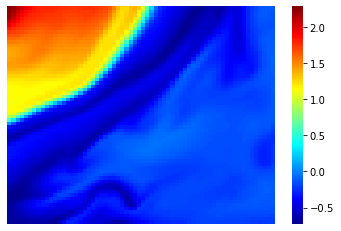

In [106]:
img = llc_io.grab_image(cutout)
ulmo_plotting.show_image(img)

In [107]:
llc_table_wo_noise['DT'] = llc_table_wo_noise['T90'] - llc_table_wo_noise['T10']

In [118]:
sub_tbl = llc_table_wo_noise[ llc_table_wo_noise.DT < 0.1]

In [119]:
diff_cutout = sub_tbl.iloc[0]
diff_cutout

modis_lat                                                    3.357648
modis_lon                                                     78.8828
modis_col                                                         678
modis_datetime                                    2012-01-01 20:20:00
modis_LL                                                   538.552185
modis_row                                                        1504
clear_fraction                                               0.049988
mean_temperature                                            27.985512
Tmin                                                        27.883001
Tmax                                                        28.161001
T90                                                         28.028002
T10                                                            27.937
modis_filename                   AQUA_MODIS.20120101T202008.L2.SST.nc
UID                                                132593357625888280
pp_file             

<AxesSubplot:>

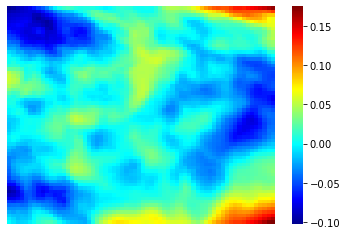

In [120]:
img1 = llc_io.grab_image(diff_cutout)
ulmo_plotting.show_image(img1)